## Importing necessary  Libraries and Tools

In [1]:
# Importing essential libraries
import numpy as np                      # For numerical operations and array handling
import pandas as pd                     # For data manipulation and analysis
import os                               # For interacting with the operating system (e.g., file paths)
import tensorflow as tf                 # Deep learning framework used for building and training models
from tqdm import tqdm                   # For displaying progress bars in loops

# Keras preprocessing utilities for images and text
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array  # Image processing
from tensorflow.keras.preprocessing.text import Tokenizer                                     # Text tokenization
from tensorflow.keras.preprocessing.sequence import pad_sequences                             # Padding sequences for uniform length

# Keras utility functions
from tensorflow.keras.utils import Sequence, to_categorical                                   # Data sequencing and one-hot encoding

# Importing model architectures and layers
from tensorflow.keras.models import Sequential, Model                                         # Model creation APIs
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, GlobalAveragePooling2D, 
                                     Activation, Dropout, Flatten, Dense, Input, Layer)       # CNN and dense layers
from tensorflow.keras.layers import (Embedding, LSTM, add, Concatenate, 
                                     Reshape, concatenate, Bidirectional)                     # Layers for text processing and fusion

# Pretrained CNN architectures for feature extraction
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201                        # Transfer learning models

# Optimizers and training callbacks
from tensorflow.keras.optimizers import Adam                                                  # Optimizer for model training
from tensorflow.keras.callbacks import (ModelCheckpoint, EarlyStopping, ReduceLROnPlateau)    # To control and monitor training process

# Visualization and warning handling
import warnings
import matplotlib.pyplot as plt         # For data visualization
import seaborn as sns                   # For enhanced visual styling
from textwrap import wrap               # For text wrapping in visualizations

# Set visualization parameters
plt.rcParams['font.size'] = 12          # Set default font size for plots
sns.set_style("dark")                   # Apply dark theme for better visuals
warnings.filterwarnings('ignore')       # Ignore unnecessary warnings for cleaner output

## Load the Dataset

In [2]:
# Define the path to the folder containing the image files
image_path = 'Images'  
# Load the caption data file into a pandas DataFrame
data = pd.read_csv("captions.txt")  

In [3]:
# Display the first few rows of the DataFrame to inspect the data
data.head()  

image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...

## Visualization

In [4]:
import os
import matplotlib.pyplot as plt
from textwrap import wrap

def readImage(path, img_size=224):
    """
    Load and preprocess a single image from disk.
    
    Parameters:
        path (str): Full file path to the image.
        img_size (int): Target size (width & height) to resize the image to (default 224).
    Returns:
        np.ndarray: Preprocessed image array of shape (img_size, img_size, 3), normalized to [0,1].
    """
    # Load the image in RGB mode, resizing to (img_size, img_size)
    img = load_img(path, color_mode='rgb', target_size=(img_size, img_size))
    # Convert PIL image to a NumPy array
    img = img_to_array(img)
    # Normalize pixel values to range [0,1] for better convergence / visualization
    img = img / 255.0
    return img

def display_images(temp_df, image_folder=r"E:\IMAGE CAPTIONING PROJECT\Images"):
    """
    Display a grid of sample images with their captions.
    
    Parameters:
        temp_df (pd.DataFrame): DataFrame containing at least columns:
            - 'image': image filenames
            - 'caption': captions associated with each image
        image_folder (str): Base folder path where image files are stored.
    """
    # Reset index to sequential 0…n in temp_df
    temp_df = temp_df.reset_index(drop=True)
    # Set up figure size for clear visualization
    plt.figure(figsize=(20, 20))
    n = 0
    # Loop over the first 15 samples (or whatever number you pick)
    for i in range(15):
        n += 1
        # Create subplot in 5x5 grid (so there might be empty spaces) to display 15 images
        plt.subplot(5, 5, n)
        plt.subplots_adjust(hspace=0.7, wspace=0.3)
        # Get the image filename from DataFrame
        img_file = temp_df.image[i]
        # Build the full absolute file path using os.path.join for cross-platform safety
        full_path = os.path.join(image_folder, img_file)
        # Load & preprocess the image
        image = readImage(full_path)
        # Display the image
        plt.imshow(image)
        # Set the title to the caption text, wrapped every ~20 characters to fit nicely
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        # Remove axes for clean display
        plt.axis("off")
    # Show the figure with all subplots
    plt.show()

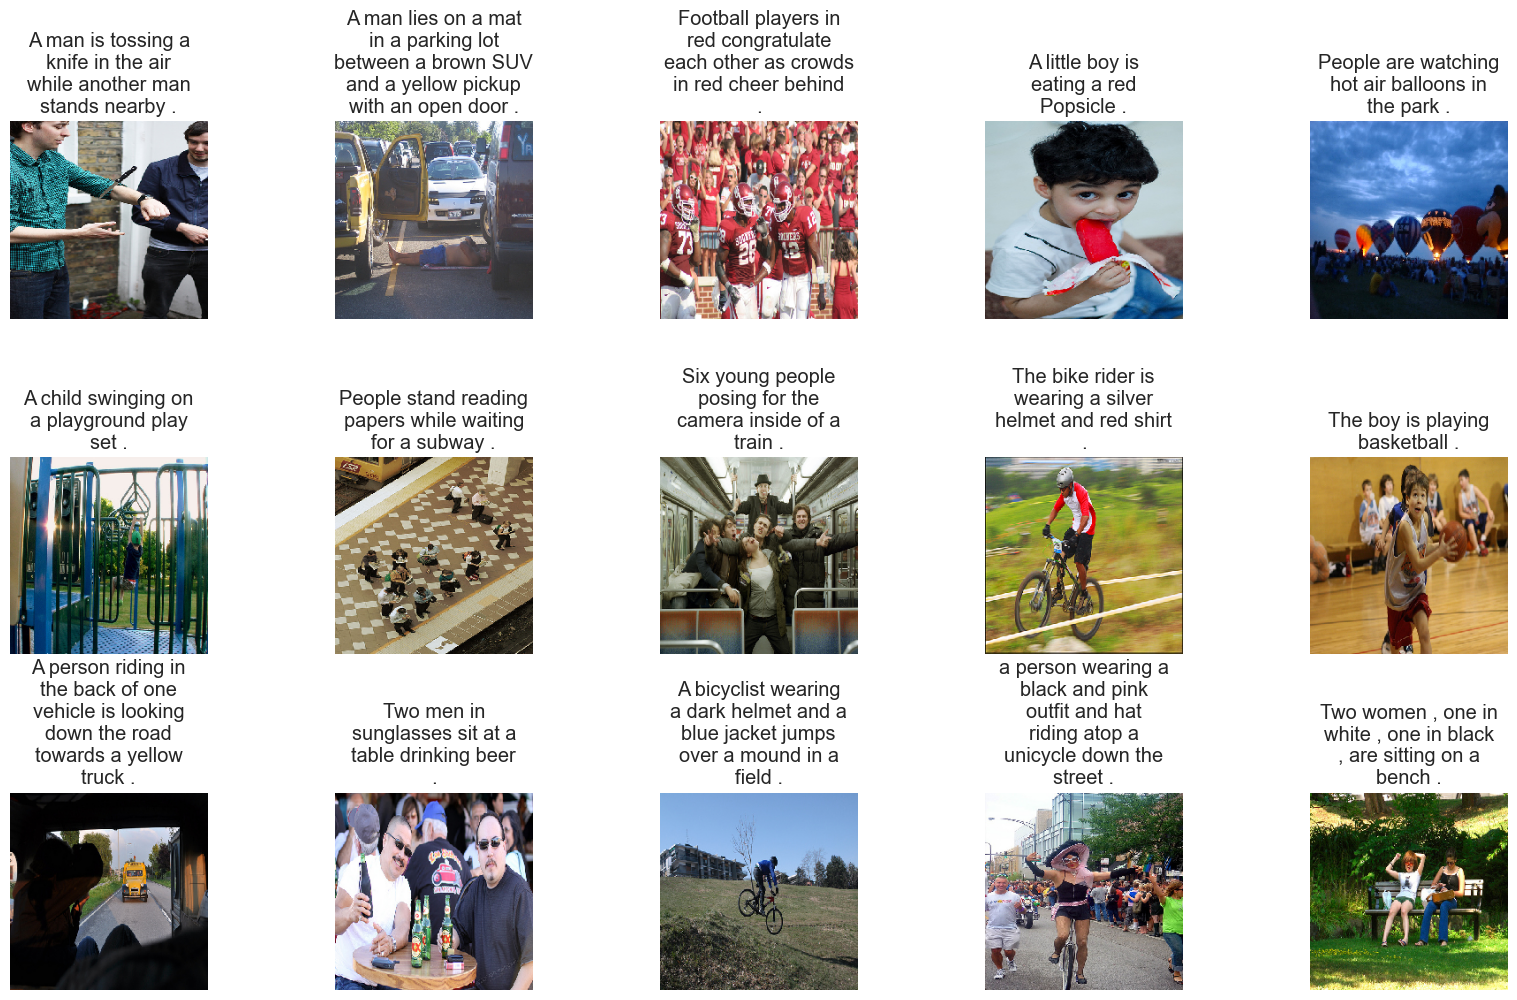

In [5]:
# Example usage: display 15 random image-caption pairs
display_images(data.sample(15))

## Caption Text Preprocessing Steps

In [6]:
def text_preprocessing(data):
    """
    Preprocess caption text for the image-captioning model.  
    Steps include: lowercasing, removing non-alphabetic characters, removing short words,
    and adding start/end tokens.
    
    Parameters:
        data (pd.DataFrame): DataFrame containing at least a column named 'caption'.
    Returns:
        pd.DataFrame: The same DataFrame with its 'caption' column updated.
    """
    # Convert all captions to lower case for uniformity
    data['caption'] = data['caption'].apply(lambda x: x.lower())
    
    # Remove all characters that are **not** lowercase or uppercase letters (i.e., keep only A-Z / a-z)
    # Here the pattern "[^A-Za-z]" means “any character not in A to Z or a to z”
    data['caption'] = data['caption'].apply(lambda x: x.replace("[^A-Za-z]",""))
    
    # Replace sequences of whitespace (one or more) with a single space
    # The pattern "\s+" means “one or more whitespace characters”
    data['caption'] = data['caption'].apply(lambda x: x.replace("\s+"," "))
    
    # Remove all words whose length is 1 (i.e., a single character word)
    # This helps reduce noise from very short words which may not carry much meaning
    data['caption'] = data['caption'].apply(
        lambda x: " ".join([word for word in x.split() if len(word)>1])
    )
    
    # Add special tokens “startseq” and “endseq” around each caption
    # These tokens will help the model know when a caption begins and ends
    data['caption'] = "startseq " + data['caption'] + " endseq"

    return data

# Apply the preprocessing on your DataFrame
data = text_preprocessing(data)

# Extract the list of preprocessed captions
captions = data['caption'].tolist()

# Print the first 10 captions to inspect
captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

## Tokenization and Encoded Representation

In [7]:
# Create a Tokenizer instance to convert captions (text) into integer sequences
tokenizer = Tokenizer()

# Fit the tokenizer on the list of captions to build the vocabulary
tokenizer.fit_on_texts(captions)  
# After this, tokenizer.word_index holds a mapping {word: integer_index} for all words. :contentReference[oaicite:0]{index=0}

# Vocabulary size is number of unique tokens + 1 (for padding token index 0)
vocab_size = len(tokenizer.word_index) + 1  

# Compute the maximum length of a caption (in words) across all captions
max_length = max(len(caption.split()) for caption in captions)

# Get the unique list of image filenames and total number of images
images = data['image'].unique().tolist()
nimages = len(images)

# Define a split index to partition data into training and validation sets (85 % training here)
split_index = round(0.85 * nimages)

# Select the first 85% of images for training
train_images = images[:split_index]
# The remaining 15% of images for validation/test
val_images = images[split_index:]

# Filter the original dataframe to get training rows (captions associated with train_images)
train = data[data['image'].isin(train_images)]
# Filter the original dataframe to get test/validation rows
test = data[data['image'].isin(val_images)]

# Reset indices of both sets (drop old index) for neatness
train.reset_index(inplace=True, drop=True)
test.reset_index(inplace=True, drop=True)

# Convert a sample caption to a sequence of integers to verify the tokenizer mapping works
tokenizer.texts_to_sequences([captions[1]])[0]

[1, 18, 315, 63, 195, 116, 2]

## Image Feature Extraction

In [8]:
import os
import numpy as np
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tqdm import tqdm

# Define the image path where your images are stored
image_path = r'E:\IMAGE CAPTIONING PROJECT\Images'

# Initialize the DenseNet201 model with pre-trained ImageNet weights
# Exclude the top classification layers to use it as a feature extractor
base_model = DenseNet201(weights='imagenet', include_top=False)

# Create a new model that outputs the second-to-last layer's features
feature_extractor = Model(inputs=base_model.input, outputs=base_model.layers[-2].output)

# Set the target image size for DenseNet201
img_size = 224

# Initialize a dictionary to store features for each image
features = {}

# Iterate over each unique image in your dataset
for image_filename in tqdm(data['image'].unique().tolist()):
    # Construct the full path to the image
    img_path = os.path.join(image_path, image_filename)
    
    # Load and preprocess the image
    img = load_img(img_path, target_size=(img_size, img_size))
    img_array = img_to_array(img) / 255.0  # Normalize pixel values to [0, 1]
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Extract features using the DenseNet201 model
    feature = feature_extractor.predict(img_array, verbose=0)
    
    # Store the extracted features in the dictionary
    features[image_filename] = feature

100%|██████████████████████████████████████████████████████████████████████████████| 8091/8091 [38:01<00:00,  3.55it/s]


## Data Generation

In [9]:
from tensorflow.keras.utils import Sequence
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm
import os

class CustomDataGenerator(Sequence):
    """
    Custom data generator for Keras to yield batches of image features and caption sequences.
    """
    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer, 
                 vocab_size, max_length, features, shuffle=True):
        """
        Initialize the data generator.

        Parameters:
        - df: DataFrame containing image filenames and captions.
        - X_col: Column name for image filenames.
        - y_col: Column name for captions.
        - batch_size: Number of samples per batch.
        - directory: Path to the directory containing images.
        - tokenizer: Keras Tokenizer instance for text processing.
        - vocab_size: Size of the vocabulary.
        - max_length: Maximum length of caption sequences.
        - features: Dictionary mapping image filenames to extracted features.
        - shuffle: Whether to shuffle the data after each epoch.
        """
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)
        
    def on_epoch_end(self):
        """
        Shuffle the data at the end of each epoch if shuffle is True.
        """
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __len__(self):
        """
        Calculate the number of batches per epoch.
        """
        return self.n // self.batch_size
    
    def __getitem__(self, index):
        """
        Generate one batch of data.

        Parameters:
        - index: Index of the batch.

        Returns:
        - A tuple containing:
          - X1: Array of image features.
          - X2: Array of padded caption sequences.
          - y: Array of one-hot encoded target words.
        """
        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size, :]
        X1, X2, y = self.__get_data(batch)        
        return (X1, X2), y

    def __get_data(self, batch):
        """
        Process a batch of data into image features, caption sequences, and target words.

        Parameters:
        - batch: DataFrame slice containing a batch of data.

        Returns:
        - X1: Array of image features.
        - X2: Array of padded caption sequences.
        - y: Array of one-hot encoded target words.
        """
        X1, X2, y = list(), list(), list()
        
        images = batch[self.X_col].tolist()
           
        for image in images:
            feature = self.features[image][0]
            
            captions = batch.loc[batch[self.X_col] == image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)
            
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                
        return X1, X2, y

# Initialize the training and validation generators
train_generator = CustomDataGenerator(df=train, X_col='image', y_col='caption', batch_size=64, 
                                      directory=image_path, tokenizer=tokenizer, vocab_size=vocab_size, 
                                      max_length=max_length, features=features)

validation_generator = CustomDataGenerator(df=test, X_col='image', y_col='caption', batch_size=64, 
                                           directory=image_path, tokenizer=tokenizer, vocab_size=vocab_size, 
                                           max_length=max_length, features=features)

In [10]:
train_generator[0]

((array([[[[ 1.64923986e-05,  1.07257289e-03, -9.72632435e-04, ...,
             1.96072257e+00, -4.89958376e-01, -9.30434823e-01],
           [-2.54508341e-05,  1.38095813e-04,  4.94454172e-04, ...,
             2.01188827e+00, -1.08716130e+00, -6.96171165e-01],
           [-1.01574740e-04,  1.85823301e-04, -1.01463927e-03, ...,
            -2.71616161e-01, -1.19639397e+00, -5.75892329e-01],
           ...,
           [-1.78477858e-04,  4.87178564e-04,  1.31328451e-03, ...,
            -4.10139978e-01, -6.60783052e-01, -6.24830246e-01],
           [ 4.71728199e-05,  1.96092203e-03,  8.58719111e-04, ...,
            -3.53188336e-01, -1.89335272e-02,  9.96631980e-02],
           [ 1.20063261e-04,  3.34513420e-03,  3.33342794e-03, ...,
            -6.30788803e-02, -5.85457869e-02,  2.44249046e-01]],
  
          [[-8.42601439e-05,  1.10555813e-03, -2.41741608e-03, ...,
             2.00455832e+00, -1.11008310e+00, -7.69865513e-01],
           [-1.06738298e-05,  1.95763865e-03, -2.6208777

## Modelling

In [16]:
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape, Embedding, LSTM, Dropout, concatenate, add
from tensorflow.keras.models import Model

# Define the model architecture for caption generation
input1 = Input(shape=(7, 7, 1920))  # Image feature map
input2 = Input(shape=(max_length,))  # Caption sequence

# Flatten the image feature map
img_features = Flatten()(input1)

# Process the image features
img_features_dense = Dense(256, activation='relu')(img_features)
img_features_reshaped = Reshape((1, 256))(img_features_dense)

# Process the caption sequence
sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)
merged = concatenate([img_features_reshaped, sentence_features], axis=1)
sentence_features = LSTM(256)(merged)

# Add dropout and dense layers
x = Dropout(0.5)(sentence_features)
x = add([x, img_features_dense])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)

# Output layer
output = Dense(vocab_size, activation='softmax')(x)

# Compile the model
caption_model = Model(inputs=[input1, input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy', optimizer='adam')

# Define callbacks for model training
model_name = "model.keras"
checkpoint = ModelCheckpoint(model_name, monitor="val_loss", mode="min", save_best_only=True, save_weights_only=False, verbose=1)
earlystopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, restore_best_weights=True)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.2, min_lr=0.00000001)

# Train the model
history = caption_model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[checkpoint, earlystopping, learning_rate_reduction]
)

Epoch 1/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 969ms/step - loss: 5.8036   
Epoch 1: val_loss improved from None to 4.41059, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 570s 1s/step - loss: 5.2358 - val_loss: 4.4106 - learning_rate: 0.0010
Epoch 2/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 961ms/step - loss: 4.4277  
Epoch 2: val_loss improved from 4.41059 to 4.07174, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 559s 1s/step - loss: 4.3509 - val_loss: 4.0717 - learning_rate: 0.0010
Epoch 3/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 956ms/step - loss: 4.1126  
Epoch 3: val_loss improved from 4.07174 to 3.94103, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 563s 1s/step - loss: 4.0841 - val_loss: 3.9410 - learning_rate: 0.0010
Epoch 4/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 3.9344  
Epoch 4: val_loss improved from 3.94103 to 3.87430, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 611s 1s/step - loss: 3.9214 - val_loss: 3.8743 - learning_rate: 0.0010
E

## Learning Curve

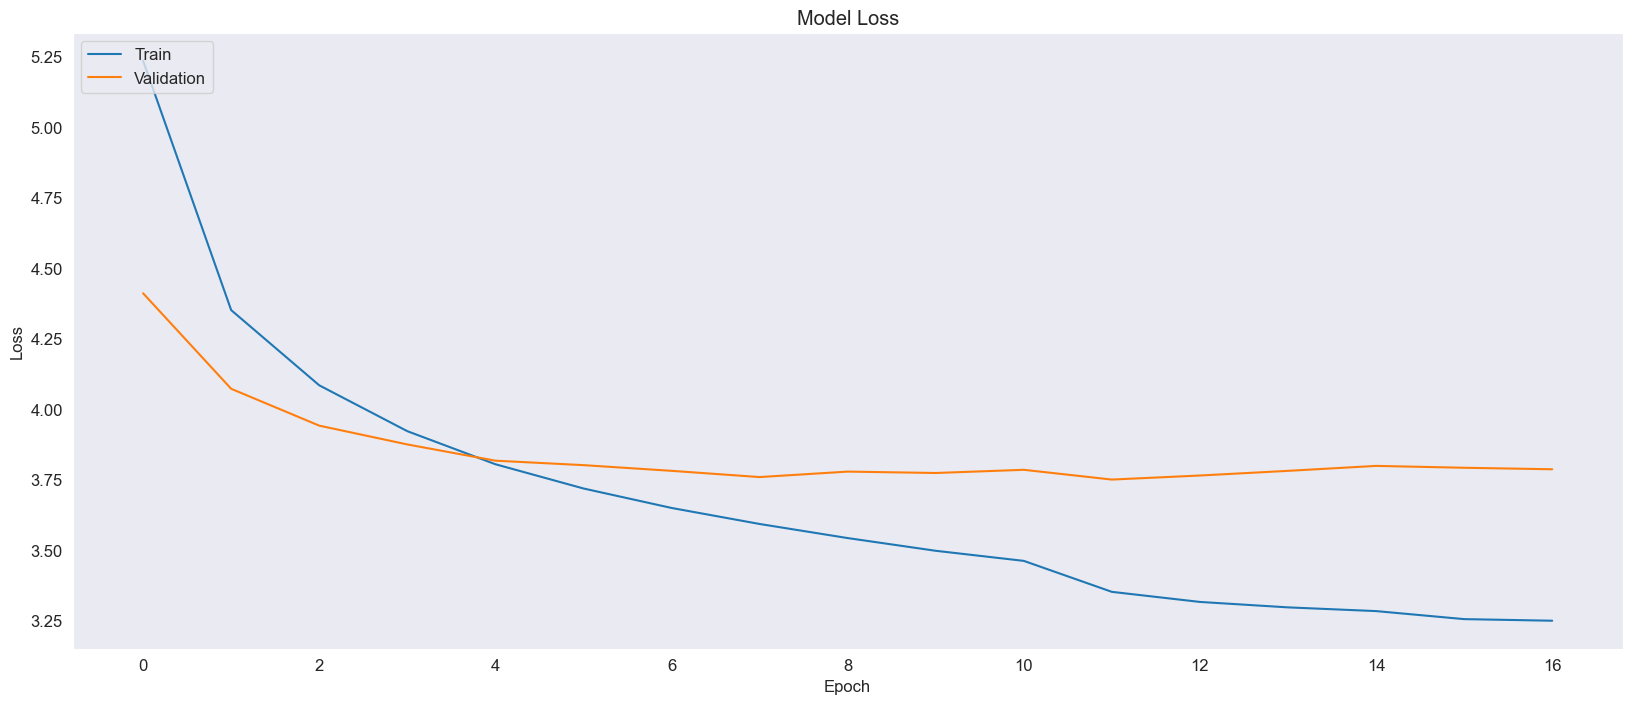

In [17]:
import matplotlib.pyplot as plt

# Create a figure with a specified size
plt.figure(figsize=(20,8))
# Plot the training loss over epochs
plt.plot(history.history['loss'])
# Plot the validation loss over epochs
plt.plot(history.history['val_loss'])
# Set the title of the plot
plt.title('Model Loss')
# Label the y-axis
plt.ylabel('Loss')
# Label the x-axis
plt.xlabel('Epoch')
# Add a legend to differentiate between training and validation loss
plt.legend(['Train', 'Validation'], loc='upper left')
# Display the plot
plt.show()

## Caption Generation Utility Functions

In [19]:
import pickle

# Save the tokenizer
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

# Save the feature extractor model
feature_extractor.save("feature_extractor.keras")

In [20]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import pickle

# Define the function to generate and display captions
def generate_and_display_caption(image_path, model_path, tokenizer_path, feature_extractor_path, max_length=34, img_size=224):
    """
    Generate a caption for a given image and display the image with the caption.
    
    Parameters:
    - image_path: str, path to the input image.
    - model_path: str, path to the trained captioning model.
    - tokenizer_path: str, path to the tokenizer used for text processing.
    - feature_extractor_path: str, path to the pre-trained feature extractor model.
    - max_length: int, maximum length of the generated caption.
    - img_size: int, target size to which the image will be resized.
    """
    # Load the trained models and tokenizer
    caption_model = load_model(model_path)  # Load the trained captioning model
    feature_extractor = load_model(feature_extractor_path)  # Load the pre-trained feature extractor model

    with open(tokenizer_path, "rb") as f:
        tokenizer = pickle.load(f)  # Load the tokenizer for text processing

    # Preprocess the image
    img = load_img(image_path, target_size=(img_size, img_size))  # Load and resize the image
    img = img_to_array(img) / 255.0  # Convert image to array and normalize pixel values
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    image_features = feature_extractor.predict(img, verbose=0)  # Extract image features using the feature extractor

    # Initialize the input sequence with the start token
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]  # Convert the input sequence to integers
        sequence = pad_sequences([sequence], maxlen=max_length)  # Pad the sequence to ensure consistent length
        yhat = caption_model.predict([image_features, sequence], verbose=0)  # Predict the next word
        yhat_index = np.argmax(yhat)  # Get the index of the predicted word
        word = tokenizer.index_word.get(yhat_index, None)  # Convert the index to the corresponding word
        if word is None:
            break  # Exit the loop if no word is found
        in_text += " " + word  # Append the predicted word to the input sequence
        if word == "endseq":
            break  # Exit the loop if the end token is predicted
    caption = in_text.replace("startseq", "").replace("endseq", "").strip()  # Remove start and end tokens and strip extra spaces

    # Display the image with the generated caption
    img = load_img(image_path, target_size=(img_size, img_size))  # Load and resize the image
    plt.figure(figsize=(8, 8))  # Set the figure size for the plot
    plt.imshow(img)  # Display the image
    plt.axis('off')  # Hide the axes
    plt.title(caption, fontsize=16, color='blue')  # Set the title of the plot to the generated caption
    plt.show()  # Show the plot

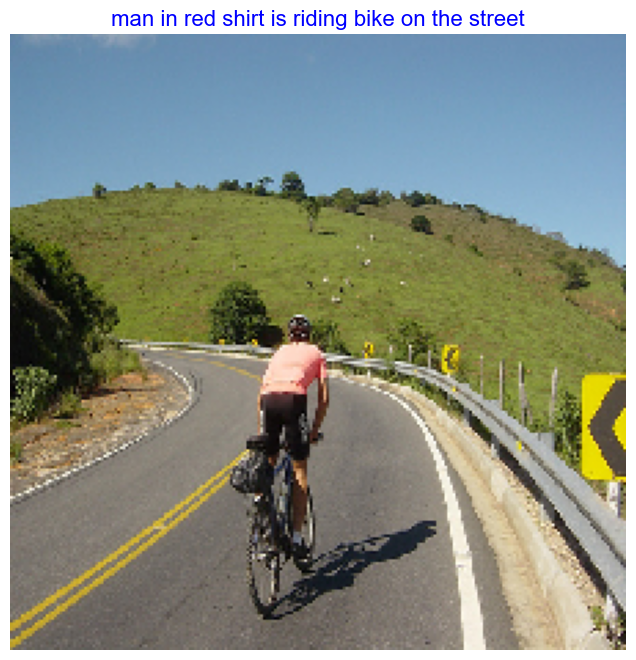

In [22]:
model_path = "model.keras"
tokenizer_path = "tokenizer.pkl"
feature_extractor_path = "feature_extractor.keras"

#Example usage
image_path = r"E:\IMAGE CAPTIONING PROJECT\Images\110595925_f3395c8bd6.jpg"  
generate_and_display_caption(image_path, model_path, tokenizer_path, feature_extractor_path)

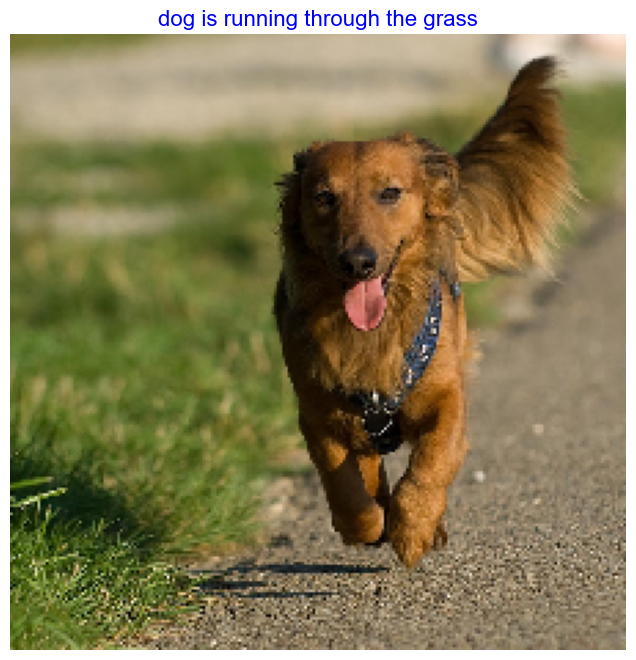

In [23]:
image_path =  r"E:\IMAGE CAPTIONING PROJECT\Images\1089181217_ee1167f7af.jpg"   
generate_and_display_caption(image_path, model_path, tokenizer_path, feature_extractor_path)

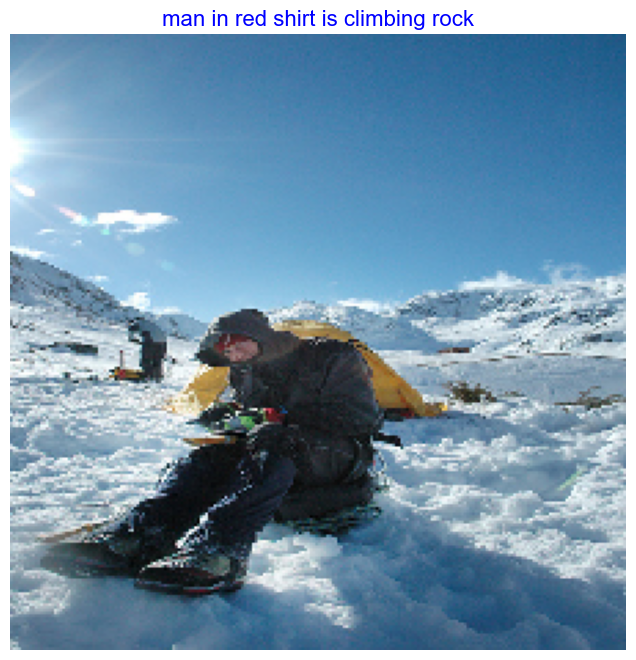

In [24]:
image_path =  r"E:\IMAGE CAPTIONING PROJECT\Images\116409198_0fe0c94f3b.jpg"  
generate_and_display_caption(image_path, model_path, tokenizer_path, feature_extractor_path)